# Linear Regression model

We are using linear regression on spark to predict the price of real estate property based on the features like age, stores, latitude, longitude, etc..

To add PySpark to sys.path for running the code on the Jupyter IDE we are Using the package findspark 

In [1]:
import pyspark
import findspark
findspark.init()
findspark.find()

'C:\\Spark\\spark-3.0.3-bin-hadoop2.7'

To perform any task on spark you need start a spark session, here we are starting a session for our linear regression.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Linear App").getOrCreate()

# Data Preprocessing and Exploration

Now we started our spark session. To start building our linear regression model we need to load and process the real estate dataset 

In [3]:
!wget https://raw.githubusercontent.com/ismayilsiyad/hpe_ml/main/Real%20estate.csv
real_estate = spark.read.csv('Real estate.csv',header= True)
real_estate.printSchema()
real_estate.show()

--2022-01-10 20:07:36--  https://raw.githubusercontent.com/ismayilsiyad/hpe_ml/main/Real%20estate.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21968 (21K) [text/plain]
Saving to: 'Real estate.csv.7'

     0K .......... .......... .                               100% 1.33M=0.02s

2022-01-10 20:07:37 (1.33 MB/s) - 'Real estate.csv.7' saved [21968/21968]



root
 |-- No: string (nullable = true)
 |-- X1 transaction date: string (nullable = true)
 |-- X2 house age: string (nullable = true)
 |-- X3 distance to the nearest MRT station: string (nullable = true)
 |-- X4 number of convenience stores: string (nullable = true)
 |-- X5 latitude: string (nullable = true)
 |-- X6 longitude: string (nullable = true)
 |-- Y house price of unit area: string (nullable = true)

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|  1|           2012.917|          32|                              84.87882|                        

# Dropping unwanted columns

We need to drop unwanted columns from the dataset. By looking into the dataset we can see columns 'No.' and  X1 transaction date' have no relevance in predicting the price. To have this insight in a complex problem. we have to formulate the hypothesis and evaluation of the hypothesis should be done.

In [4]:
colm = ['No','X1 transaction date']
re_df = real_estate.select([column for column in real_estate.columns if column not in colm])
re_df.printSchema()

root
 |-- X2 house age: string (nullable = true)
 |-- X3 distance to the nearest MRT station: string (nullable = true)
 |-- X4 number of convenience stores: string (nullable = true)
 |-- X5 latitude: string (nullable = true)
 |-- X6 longitude: string (nullable = true)
 |-- Y house price of unit area: string (nullable = true)



# Changing the column datatype

We need to change column datatype to float from the initial string datatype

In [5]:
from pyspark.sql.functions import col
re_df = re_df.select(*(col(c).cast('float').alias(c) for c in re_df.columns))
re_df.printSchema()

root
 |-- X2 house age: float (nullable = true)
 |-- X3 distance to the nearest MRT station: float (nullable = true)
 |-- X4 number of convenience stores: float (nullable = true)
 |-- X5 latitude: float (nullable = true)
 |-- X6 longitude: float (nullable = true)
 |-- Y house price of unit area: float (nullable = true)



# Taking the count of the null and missing values

In [6]:
from pyspark.sql.functions import col, count, isnan, when
re_df.select([count(when(col(c).isNull(), c)).alias(c) for c in re_df.columns]).show()

+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|           0|                                     0|                              0|          0|           0|                         0|
+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+



Since the count is zero we need not do anything further. If the count is nonzero we have to remove or substitute these values. One more preproceessing that we re doing is to reduce the lengthy names of each column to managable smaller names.

In [6]:
from functools import reduce

oldColumns = re_df.schema.names
newColumns = ['Age','Distance_2_MRT','Stores','Latitude','Longitude','Price']

re_df = reduce(lambda re_df, idx: re_df.withColumnRenamed(oldColumns[idx], newColumns[idx]),range(len(oldColumns)), re_df)
re_df.printSchema()
re_df.show()

root
 |-- Age: float (nullable = true)
 |-- Distance_2_MRT: float (nullable = true)
 |-- Stores: float (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Price: float (nullable = true)

+----+--------------+------+--------+---------+-----+
| Age|Distance_2_MRT|Stores|Latitude|Longitude|Price|
+----+--------------+------+--------+---------+-----+
|32.0|      84.87882|  10.0|24.98298|121.54024| 37.9|
|19.5|      306.5947|   9.0|24.98034|121.53951| 42.2|
|13.3|      561.9845|   5.0|24.98746|121.54391| 47.3|
|13.3|      561.9845|   5.0|24.98746|121.54391| 54.8|
| 5.0|      390.5684|   5.0|24.97937|121.54245| 43.1|
| 7.1|       2175.03|   3.0|24.96305|121.51254| 32.1|
|34.5|      623.4731|   7.0|24.97933|121.53642| 40.3|
|20.3|      287.6025|   6.0|24.98042|121.54228| 46.7|
|31.7|      5512.038|   1.0|24.95095|121.48458| 18.8|
|17.9|       1783.18|   3.0|24.96731|121.51486| 22.1|
|34.8|      405.2134|   1.0|24.97349|121.53372| 41.4|
| 6.3| 

# Visualizing the data

We are using an open visualization library Matplotlib for visualizing our real estate data

C:\Users\ISMAYI~1\AppData\Local\Temp/ipykernel_7660/1293496851.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


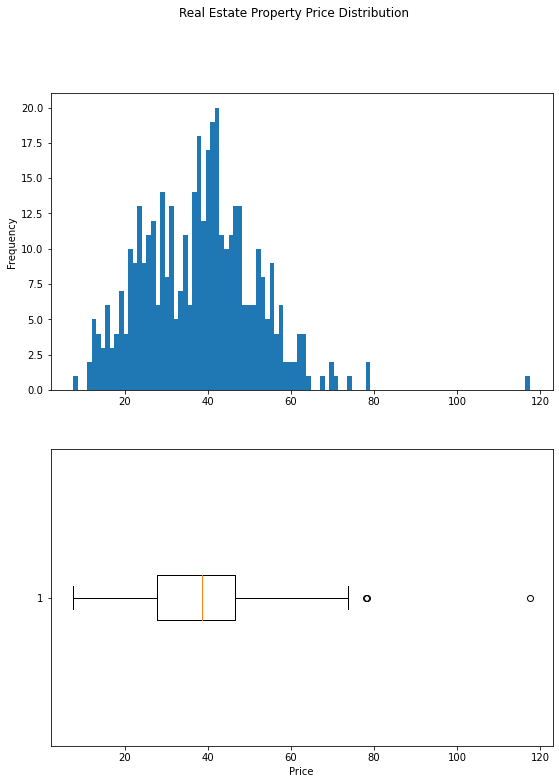

In [7]:
from pyspark.sql.functions import col

import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the Jupyter notebook
%matplotlib inline

# Get the label column

label = re_df.select(col("price"))
label = label.select("price").rdd.flatMap(lambda x: x).collect()


# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Price')

# Add a title to the Figure
fig.suptitle('Real Estate Property Price Distribution')

# Show the figure
fig.show()

# List of columns to vector form

We are using VectorAssembler to convert the list columns in our dataset to vector form in which all the features are grouped to vector form

In [8]:
features = re_df.drop('Price')
from pyspark.ml.feature import VectorAssembler
#let's assemble our features together using vectorAssembler
assembler = VectorAssembler(
    inputCols=features.columns,
    outputCol="features")
output = assembler.transform(re_df).select('features','Price')

# Splitting the data into training and testing datasets

The dataset in vector form is now splitting into train and test datset fractions

In [9]:
train,test = output.randomSplit([0.75, 0.25])
train.show()
test.show()

+--------------------+-----+
|            features|Price|
+--------------------+-----+
|[0.0,185.42959594...| 37.9|
|[0.0,185.42959594...| 45.5|
|[0.0,185.42959594...| 55.3|
|[0.0,208.39050292...| 44.0|
|[0.0,208.39050292...| 45.7|
|[0.0,274.01440429...| 45.4|
|[0.0,274.01440429...| 52.2|
|[0.0,292.99780273...| 63.3|
|[0.0,292.99780273...| 70.1|
|[0.0,292.99780273...| 71.0|
|[0.0,292.99780273...| 73.6|
|[0.0,338.96789550...| 44.9|
|[0.0,338.96789550...| 50.8|
|[1.0,193.58450317...| 50.7|
|[1.10000002384185...| 45.1|
|[1.10000002384185...| 48.6|
|[1.10000002384185...| 49.0|
|[1.10000002384185...| 54.4|
|[1.5,23.382839202...| 47.7|
|[1.70000004768371...| 50.4|
+--------------------+-----+
only showing top 20 rows

+--------------------+-----+
|            features|Price|
+--------------------+-----+
|[0.0,185.42959594...| 52.2|
|[0.0,185.42959594...| 55.2|
|[0.0,274.01440429...| 43.5|
|[0.0,292.99780273...| 69.7|
|[1.10000002384185...| 51.8|
|[1.5,23.382839202...| 49.7|
|[2.0,2077.389892

# Linear Regression Model

Now we are using linear regression model from pyspark.ml library, and loading our data to the model for training. The coefficients and intercepts(biases) are printed

In [10]:
from pyspark.ml.regression import LinearRegression
lin_reg = LinearRegression(featuresCol = 'features', labelCol='Price')
linear_model = lin_reg.fit(train)
print("Coefficients: " + str(linear_model.coefficients))
print("\nIntercept: " + str(linear_model.intercept))

Coefficients: [-0.22237639810639395,-0.00381927186250921,1.2533949125015702,229.05236864876784,25.08402354121359]

Intercept: -8726.995009217282


# Evaluation of Model
The summary of the training process is listed below using model.summary


In [11]:
trainSummary = linear_model.summary
print("RMSE: %f" % trainSummary.rootMeanSquaredError)
#print("\nr2: %f" % trainSummary.r2)

RMSE: 8.249858


# Regression Evaluation

We can compare actual price with the predicted price based on error values such as Mean Absolute Error and Root Mean Squared Error Values

In [14]:

predictions = linear_model.transform(test)


from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator1 = RegressionEvaluator(
    labelCol="Price", predictionCol="prediction", metricName="mae")
mae = evaluator1.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

Root Mean Squared Error (RMSE) on test data = 10.8872
Mean Absolute Error (MAE) on test data = 6.52707


# R Squared (R2) value

We can use RegressionEvaluator for the coefficient of determination

In [14]:
from pyspark.ml.evaluation import RegressionEvaluator
pred_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Price",metricName="r2")
print("Coefficient of determination = %g" % pred_evaluator.evaluate(predictions))

Coefficient of determination = 0.675433


# Random Forest Regression Model

Now we are using Random Forest regression model from pyspark.ml library, and loading our data to the model for training.


Automatically identify categorical features, and index them. Set maxCategories so features with > 4 distinct values are treated as continuous.

In [15]:
from pyspark.ml.feature import VectorIndexer
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(output)

output = output.withColumnRenamed("Price","label")
train,test = output.randomSplit([0.75, 0.25])
train.show()
test.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,185.42959594...| 52.2|
|[0.0,185.42959594...| 55.2|
|[0.0,185.42959594...| 55.3|
|[0.0,208.39050292...| 44.0|
|[0.0,274.01440429...| 43.5|
|[0.0,274.01440429...| 52.2|
|[0.0,292.99780273...| 63.3|
|[0.0,292.99780273...| 69.7|
|[0.0,292.99780273...| 71.0|
|[0.0,292.99780273...| 73.6|
|[0.0,338.96789550...| 44.9|
|[1.0,193.58450317...| 50.7|
|[1.10000002384185...| 45.1|
|[1.10000002384185...| 54.4|
|[1.10000002384185...| 51.8|
|[1.5,23.382839202...| 47.7|
|[1.5,23.382839202...| 49.7|
|[1.70000004768371...| 50.4|
|[1.79999995231628...| 27.0|
|[1.89999997615814...| 40.5|
+--------------------+-----+
only showing top 20 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,185.42959594...| 37.9|
|[0.0,185.42959594...| 45.5|
|[0.0,208.39050292...| 45.7|
|[0.0,274.01440429...| 45.4|
|[0.0,292.99780273...| 70.1|
|[0.0,338.96789550...| 50.8|
|[1.1000000238418

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor


rf = RandomForestRegressor(featuresCol="indexedFeatures")

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

#lin_reg = LinearRegression(featuresCol = 'features', labelCol='Price')
#linear_model = lin_reg.fit(train)
#print("Coefficients: " + str(linear_model.coefficients))
#print("\nIntercept: " + str(linear_model.intercept))

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
| 50.52579361584997| 37.9|[0.0,185.42959594...|
| 50.52579361584997| 45.5|[0.0,185.42959594...|
| 49.14776708164011| 45.7|[0.0,208.39050292...|
| 48.18700440972138| 45.4|[0.0,274.01440429...|
|62.838946605485546| 70.1|[0.0,292.99780273...|
+------------------+-----+--------------------+
only showing top 5 rows



# Evaluation of Model
The summary of the training process is listed below using model.summary


In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator1 = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator1.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)
rfModel = model.stages[1]
print(rfModel)  # summary only

Root Mean Squared Error (RMSE) on test data = 9.80504
Mean Absolute Error (MAE) on test data = 5.20557
RandomForestRegressionModel: uid=RandomForestRegressor_23c0ec0686cd, numTrees=20, numFeatures=5


# R Squared (R2) value

We can use RegressionEvaluator for the coefficient of determination

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()
evaluator.setPredictionCol("label")
acc=evaluator.evaluate(predictions)
mae=evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
pred_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("Coefficient of determination = %g" % pred_evaluator.evaluate(predictions))


Coefficient of determination = 0.608094


In [19]:
spark.stop()